# Generate LSST Spectrum using PySynPhot
=========================================================================


The purpose is to start to use PySynPhot software to calculate things on
SED, filter transmission,... For Calibration

- Sylvie Dagoret-Campagne
- Affiliation LAL-IN2P3-CNRS
- Work : LSST & StarDice
- creation date June 17th 2017
- update : October 17th 2017


- Read filters for LSST provided by KG May 30th 2017
- Generate LibRadTran atmosphere for any airmass - H2O - O3 combinations for LSST
- Generate the observed spectrum

In [3]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import pandas as pd
import os
import re

In [5]:
import astropy.units as u

In [6]:
import sys
sys.path.append('./libradtransim')

In [7]:
from libsimulateTranspLSSTScattAbs import *

In [8]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [9]:
os.environ['PYSYN_CDBS']

'/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs'

In [10]:
import pysynphot as S

# Defining LSST telescope

In [11]:
LSST_COLL_SURF=35*(u.m)**2/(u.cm)**2  # LSST collectif surface
WLMIN=3000.
WLMAX=11000.

In [12]:
LSST_COLL_SURF.decompose()

<Quantity 350000.0>

In [13]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 45238.93416


In [14]:
S.refs.setref(area=LSST_COLL_SURF.decompose(), waveset=None)

In [15]:
S.refs.set_default_waveset(minwave=3000, maxwave=11000, num=8000, delta=10, log=False)

In [16]:
S.refs.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 10, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 350000.0


In [17]:
plt.ion()
plt.clf()

## Filters and CCD


In [18]:
files_idealfilters=['LSSTFiltersKG/fdata/ideal_u.txt','LSSTFiltersKG/fdata/ideal_g.txt','LSSTFiltersKG/fdata/ideal_r.txt','LSSTFiltersKG/fdata/ideal_i.txt','LSSTFiltersKG/fdata/ideal_z.txt','LSSTFiltersKG/fdata/ideal_y4.txt']

In [19]:
file_lsstoptccd='LSSTFiltersKG/fdata/LSST-ThroughputCCD.xlsx'

In [20]:
NBFILES=len(files_idealfilters)

### Read filters

In [21]:
data_u=np.loadtxt(files_idealfilters[0],skiprows=2)
data_g=np.loadtxt(files_idealfilters[1],skiprows=2)
data_r=np.loadtxt(files_idealfilters[2],skiprows=2)
data_i=np.loadtxt(files_idealfilters[3],skiprows=2)
data_z=np.loadtxt(files_idealfilters[4],skiprows=2)
data_y4=np.loadtxt(files_idealfilters[5],skiprows=2)

In [22]:
wl_u=data_u[:,0]
u=data_u[:,1]
#
wl_g=data_g[:,0]
g=data_g[:,1]
#
wl_r=data_r[:,0]
r=data_r[:,1]
#
wl_i=data_i[:,0]
i=data_i[:,1]
#
wl_z=data_z[:,0]
z=data_z[:,1]
#
wl_y4=data_y4[:,0]
y4=data_y4[:,1]

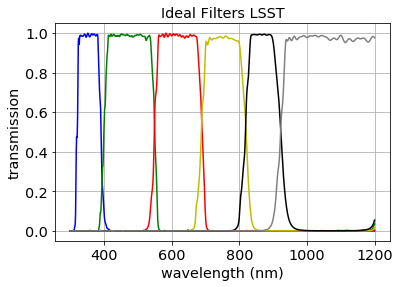

In [23]:
plt.plot(wl_u,u,'b-')
plt.plot(wl_g,g,'g-')
plt.plot(wl_r,r,'r-')
plt.plot(wl_i,i,'y-')
plt.plot(wl_z,z,'k-')
plt.plot(wl_y4,y4,'-',color='grey')
plt.grid()
plt.title("Ideal Filters LSST")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")

### Read Throughput et CCD

In [24]:
data_throuthput=pd.read_excel(file_lsstoptccd,skiprow=1)

### Read throughtput and ccd

In [25]:
wl2=np.array(data_throuthput["WL"])
throughput=np.array(data_throuthput["THROUGHPUT"])
ccdqe=np.array(data_throuthput["CCD2"])
trans_opt_elec=np.array(data_throuthput["THROUGHPUT"]*data_throuthput["CCD2"])

In [26]:
type(wl2)

numpy.ndarray

In [27]:
out_throughput=np.stack((wl2,throughput),axis=1)

In [28]:
out_throughput

array([[  3.00000000e+02,   3.27074795e-01],
       [  3.01000000e+02,   3.37936895e-01],
       [  3.02000000e+02,   3.49235958e-01],
       ..., 
       [  1.19800000e+03,   8.46759501e-01],
       [  1.19900000e+03,   8.44010373e-01],
       [  1.20000000e+03,   8.44661318e-01]])

In [29]:
np.savetxt('ctio_throughput.txt',  out_throughput)

In [30]:
plt.plot(data_throuthput["WL"],data_throuthput["THROUGHPUT"],'b-',label='throughput')
plt.plot(data_throuthput["WL"],data_throuthput["CCD2"],'r-',label='CCD-QE')
plt.plot(data_throuthput["WL"],trans_opt_elec,'k-',label='Comb')
plt.grid()
plt.title("LSST Throughput and CCD QE")
plt.xlabel("wavelength")
plt.ylabel("transmission")
plt.legend()

### Combine

In [31]:
trans_opt_elec_u=trans_opt_elec[0:u.shape[0]]
trans_opt_elec_g=trans_opt_elec[0:g.shape[0]]
trans_opt_elec_r=trans_opt_elec[0:r.shape[0]]
trans_opt_elec_i=trans_opt_elec[0:i.shape[0]]
trans_opt_elec_z=trans_opt_elec[0:z.shape[0]]
trans_opt_elec_y4=trans_opt_elec[0:y4.shape[0]]

In [32]:
tot_u=np.array(u*trans_opt_elec_u)
tot_g=np.array(g*trans_opt_elec_g)
tot_r=np.array(r*trans_opt_elec_r)
tot_i=np.array(i*trans_opt_elec_i)
tot_z=np.array(z*trans_opt_elec_z)
tot_y4=np.array(y4*trans_opt_elec_y4)

In [33]:
tot_y4[np.where(wl2>1100)]=0

In [34]:
plt.plot(wl_u,tot_u,'b-')
plt.plot(wl_g,tot_g,'g-')
plt.plot(wl_r,tot_r,'r-')
plt.plot(wl_i,tot_i,'y-')
plt.plot(wl_z,tot_z,'k-')
plt.plot(wl_y4,tot_y4,'-',color='grey')
plt.grid()
plt.title("Total transmission LSST (no atm)")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")
plt.savefig("lsst-total-transm.png")

## Read atmosphere

In [35]:
path,file=ProcessSimulation(1.,4.,300.) 

--------------------------------------------
 2) airmass =  1.0
 2) pwv =  4.0
 2) oz =  300.0
--------------------------------------------
('Running uvspec with input file: ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30.INP')
('Output to file                : ', 'simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30.OUT')
('uvspec cmd: ', '/Users/dagoret//MacOSX/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z10_wv40_oz30.INP > simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z10_wv40_oz30.OUT')


In [36]:
fullfilename=os.path.join(path,file)

In [37]:
atm_data=np.loadtxt(fullfilename)

In [38]:
wl_atm=atm_data[:,0]
tr_atm=atm_data[:,1]

In [39]:
plt.plot(wl_atm,tr_atm)
plt.grid()
plt.title(" atmosphere)")
plt.xlabel("wavelength (nm)")
plt.ylabel("transmission")
plt.savefig("atm-transm.png")

# Pysynphot

In [40]:
bp_u = S.ArrayBandpass(wl_u*10.,tot_u, name='LSST_U')
bp_g = S.ArrayBandpass(wl_g*10.,tot_g, name='LSST_G')
bp_r = S.ArrayBandpass(wl_r*10,tot_r, name='LSST_R')
bp_i = S.ArrayBandpass(wl_i*10.,tot_i, name='LSST_I')
bp_z = S.ArrayBandpass(wl_z*10.,tot_z, name='LSST_Z')
bp_y4 = S.ArrayBandpass(wl_y4*10,tot_y4, name='LSST_Y4')
bp_atm= S.ArrayBandpass(wl_atm*10.,tr_atm, name='LSST_ATM')

In [41]:
bp_u_atm = bp_u*bp_atm
bp_g_atm = bp_g*bp_atm
bp_r_atm = bp_r*bp_atm
bp_i_atm = bp_i*bp_atm
bp_z_atm = bp_z*bp_atm
bp_y4_atm = bp_y4*bp_atm

In [42]:
bp_u_atm.binning=10.
bp_g_atm.binning=10.
bp_r_atm.binning=10.
bp_i_atm.binning=10.
bp_z_atm.binning=10.
bp_y4_atm.binning=10.

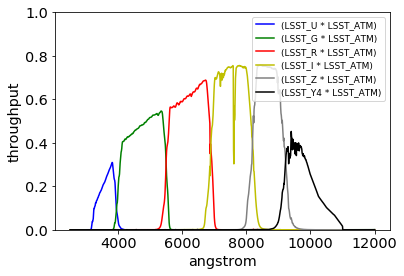

In [43]:
plt.plot(bp_u_atm.wave, bp_u_atm.throughput, 'b')
plt.plot(bp_g_atm.wave, bp_g_atm.throughput, 'g')
plt.plot(bp_r_atm.wave, bp_r_atm.throughput, 'r')
plt.plot(bp_i_atm.wave, bp_i_atm.throughput, 'y')
plt.plot(bp_z_atm.wave, bp_z_atm.throughput, color='grey')
plt.plot(bp_y4_atm.wave, bp_y4_atm.throughput,'k')
plt.ylim(0, 1.)
plt.xlabel(bp_u_atm.waveunits)
plt.ylabel('throughput')
plt.legend([bp_u_atm.name, bp_g_atm.name,bp_r_atm.name, bp_i_atm.name,bp_z_atm.name, bp_y4_atm.name], loc=1,fontsize=9)

# Observation

In [44]:
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
sed = S.FileSpectrum(filename)
sed.flux

array([  2.16790002e-14,   2.66180002e-14,   2.03460007e-14, ...,
         9.32662788e-19,   9.23448099e-19,   9.14324504e-19])

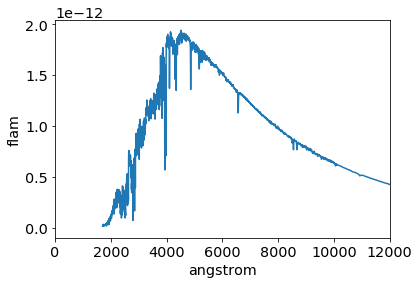

In [45]:
plt.plot(sed.wave,sed.flux)
plt.xlim(0.,12000)
plt.xlabel(sed.waveunits)
plt.ylabel(sed.fluxunits)
#plt.title(S.Vega.name)

In [46]:
obs_u = S.Observation(sed,bp_u_atm)
obs_g = S.Observation(sed,bp_g_atm)
obs_r = S.Observation(sed,bp_r_atm)
obs_i = S.Observation(sed,bp_i_atm)
obs_z = S.Observation(sed,bp_z_atm)
obs_y4 = S.Observation(sed,bp_y4_atm)

((LSST_U * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_G * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_R * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_I * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Z * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((LSST_Y4 * LSST_ATM)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


In [47]:
obs_u.primary_area=LSST_COLL_SURF.decompose()
obs_g.primary_area=LSST_COLL_SURF.decompose()
obs_r.primary_area=LSST_COLL_SURF.decompose()
obs_i.primary_area=LSST_COLL_SURF.decompose()
obs_z.primary_area=LSST_COLL_SURF.decompose()
obs_y4.primary_area=LSST_COLL_SURF.decompose()

In [48]:
print obs_u.primary_area
print obs_g.primary_area
print obs_r.primary_area
print obs_i.primary_area
print obs_z.primary_area
print obs_y4.primary_area

350000.0
350000.0
350000.0
350000.0
350000.0
350000.0


/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd111980_stis_003.fits * (LSST_U * LSST_ATM)


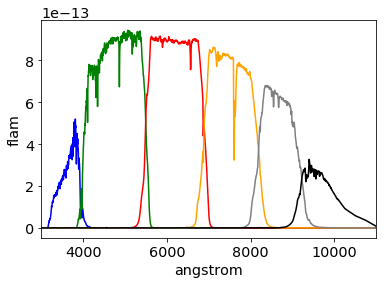

In [49]:
plt.plot(obs_u.wave,obs_u.flux,'b')
plt.plot(obs_g.wave,obs_g.flux,'g')
plt.plot(obs_r.wave,obs_r.flux,'r')
plt.plot(obs_i.wave,obs_i.flux,color='orange')
plt.plot(obs_z.wave,obs_z.flux,color='grey')
plt.plot(obs_y4.wave,obs_y4.flux,'k')
plt.xlim(WLMIN,WLMAX)
plt.xlabel(obs_u.waveunits)
plt.ylabel(obs_u.fluxunits)
#plt.title(S.Vega.name)
print obs_u.name

In [50]:
plt.plot(obs_u.binwave,obs_u.binflux,'b',drawstyle='steps-mid')
plt.plot(obs_g.binwave,obs_g.binflux,'g',drawstyle='steps-mid')
plt.plot(obs_r.binwave,obs_r.binflux,'r',drawstyle='steps-mid')
plt.plot(obs_i.binwave,obs_i.binflux,color='orange',drawstyle='steps-mid')
plt.plot(obs_z.binwave,obs_z.binflux,color='grey',drawstyle='steps-mid')
plt.plot(obs_y4.binwave,obs_y4.binflux,'k',drawstyle='steps-mid')
plt.xlabel(obs_u.waveunits)
plt.ylabel(obs_u.fluxunits)
plt.xlim(WLMIN,WLMAX)
#plt.title(sed.name)
print obs_u.name

/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/calspec/hd111980_stis_003.fits * (LSST_U * LSST_ATM)


In [51]:
print obs_u.primary_area

350000.0


### Magnitude

In [52]:
print obs_u.effstim('obmag') 

-17.8028315062


In [53]:
-2.5*np.log10(obs_u.binflux.sum())

25.320009421076072

In [54]:
obs_u.convert('counts')

# Reference data

In [55]:
 S.showref()

thermtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits
   waveset: Min: 3000, Max: 11000, Num: None, Delta: 10, Log: False
 comptable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0ac1951am_tmc.fits
graphtable: /Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/0bf2050hm_tmg.fits
      area: 350000.0


# Catalog

In [56]:
from astropy.io import fits
filename = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'hd111980_stis_003.fits')
with fits.open(filename) as pf:
    print(pf[1].header)

XTENSION= 'BINTABLE'           /Written by IDL:  Wed Dec 24 09:03:03 2014       BITPIX  =                    8 /                                                NAXIS   =                    2 /Binary table                                    NAXIS1  =                   30 /Number of bytes per row                         NAXIS2  =                 3739 /Number of rows                                  PCOUNT  =                    0 /Random parameter count                          GCOUNT  =                    1 /Group count                                     TFIELDS =                    7 /Number of columns                               EXTNAME = 'SCI     '           /                                                EXTVER  =                    1 /                                                INHERIT =                    T /                                                TFORM1  = '1D      '           /Real*8 (double precision)                       TTYPE1  = 'WAVELENGTH'         /Label fo